In [1]:
import torch
from torch import nn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from typing import List, Tuple, Dict, Callable

import time

In [2]:
from IPython.display import display as d

In [3]:
from omegaconf import OmegaConf

## Some solutions of PDE (partial differential equations)

In [4]:
N = 10_000

x: torch.Tensor = torch.empty(size=(N, ))
x.uniform_(0, 1)


y: torch.Tensor = torch.empty(size=(N, ))
y.uniform_(0, 1)
# t: torch.Tensor = torch.empty(size=(batch_size, 1))
# t.uniform_(0, 10)

u: List # u = u(x, t)

In [5]:
u = torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

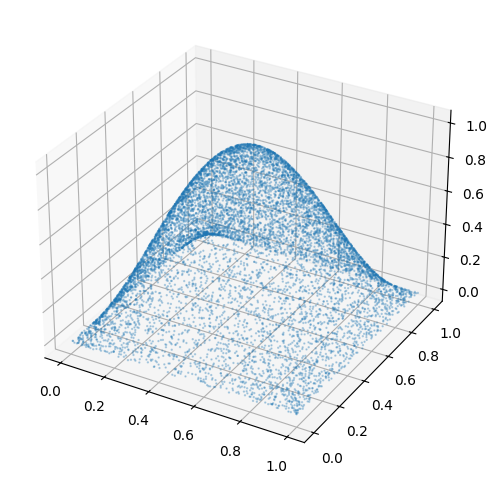

In [6]:
ax = plt.figure(figsize=(6, 6)).add_subplot(projection="3d")

ax.scatter(x, y, u, s=0.5, alpha=0.3)

plt.show()

In [7]:
plt.close("all")

## PINN for solving PDE

In [4]:
from src.data.components.dataset import SpatialTemporalDomain, SpatialTemporalDomain2D
from src.data.components.collate import BaseCollator, ModelInput, SingleForwardState, Coords, ModelBatch

In [19]:
d(torch.linspace(0, 5, 11))

tensor([0.0000, 0.5000, 1.0000, 1.5000, 2.0000, 2.5000, 3.0000, 3.5000, 4.0000,
        4.5000, 5.0000])

In [61]:
class SpatialTemporalDomain(torch.utils.data.Dataset):
    def __init__(
            self, 
            coords_limits: Dict[str, List[float]],
            time_limits: Dict[str, float],
            n_samples: int = 100_000, 
            noise: float = 0.0
        ) -> None:

        self.data_size = n_samples

        coords = dict()

        for coord_key, coord_limits in coords_limits.items():
            X: torch.Tensor = torch.linspace(coord_limits[0], coord_limits[1], n_samples).unsqueeze(dim=-1)

            X += noise * torch.randn(size=(X.size()))

            coords[coord_key] = X

        self.coords = coords

        self.T: torch.Tensor = torch.linspace(time_limits[0], time_limits[1], n_samples)

        self.T += noise * torch.randn(size=(self.T.size()))
        

    def __getitem__(self, idx: int):
        return {
            "coords": {
                coord_key: coord[idx] for coord_key, coord in self.coords.items()
            },
            "time": self.T[idx]
        }

    def __len__(self):
        return self.data_size

In [62]:
dataset = SpatialTemporalDomain(coords_limits={"x": [-10, 10]}, time_limits=[0, 10], n_samples=100_000)

In [63]:
d(dataset.T)

tensor([0.0000e+00, 1.0000e-04, 2.0000e-04,  ..., 9.9998e+00, 9.9999e+00,
        1.0000e+01])

In [29]:
BATCH_SIZE = 32

In [ ]:
class SequentialSampler(torch.utils.data.Sampler):
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self) -> int:
        return len(self.indices)

In [175]:
class BaseCollator2D:
    def __init__(self, with_coords: bool = True, with_time: bool = True, seq_len: int = 128):
        self.with_coords = with_coords
        self.with_time = with_time
        self.seq_len = seq_len

    def __call__(self, batch: List[Dict]) -> ModelBatch:
        batch_size = len(batch)

        if self.with_coords:
            coords_keys = ["x", "y", "z"]

            coords = dict().fromkeys(coords_keys)

            for key in batch[0]["coords"].keys():
                coords[key] = torch.stack([item["coords"][key] for item in batch], dim=0).view(len(batch) * self.seq_len, 1)

                coords[key].requires_grad_(True)
        else:
            coords = None

        if self.with_time:
            time = torch.stack([item["time"] for item in batch], dim=0).view(len(batch) * self.seq_len, 1)

            time.requires_grad_(True)
        else:
            time = None

        return ModelBatch(
            coords=Coords(**coords), 
            time=time
        )

In [176]:
train_loader = torch.utils.data.DataLoader(
    dataset=train, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    collate_fn=BaseCollator2D()
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    collate_fn=BaseCollator2D()
)

In [177]:
sample = next(iter(train_loader))

In [185]:
d(sample.coords.x.view(32, 128, 1)[3])

tensor([[-3.7113],
        [-3.6948],
        [-3.7160],
        [-3.7009],
        [-3.7089],
        [-3.7151],
        [-3.7120],
        [-3.7010],
        [-3.7112],
        [-3.7063],
        [-3.7119],
        [-3.7040],
        [-3.7152],
        [-3.6957],
        [-3.7020],
        [-3.7080],
        [-3.7064],
        [-3.7130],
        [-3.7040],
        [-3.6968],
        [-3.7109],
        [-3.7078],
        [-3.7039],
        [-3.6953],
        [-3.7123],
        [-3.7165],
        [-3.7031],
        [-3.7061],
        [-3.7009],
        [-3.7010],
        [-3.7090],
        [-3.7016],
        [-3.7072],
        [-3.7109],
        [-3.6977],
        [-3.6995],
        [-3.7014],
        [-3.7029],
        [-3.7001],
        [-3.7008],
        [-3.6973],
        [-3.6975],
        [-3.7021],
        [-3.6973],
        [-3.6958],
        [-3.7016],
        [-3.7065],
        [-3.6935],
        [-3.7053],
        [-3.7135],
        [-3.7004],
        [-3.7160],
        [-3.

In [58]:
from src.models.pde_lit_model_xt import PDELitModule
from src.models.components.pde_nn import PDESimpleNN
from src.models.components.linear_blocks.linear_down_up_block import LinearDownUpBlock

In [59]:
class PDEBurgerCondition(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs: ModelInput) -> torch.Tensor:
        return torch.zeros(size=inputs.time.size())


class PDEOtherCondition(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs: ModelInput) -> torch.Tensor:
        return torch.zeros(size=inputs.time.size())


class InitialConditions(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, coords: Coords) -> torch.Tensor:
        # return torch.zeros(coords.x.size())
        return torch.exp(-torch.square(coords.x) / 2)


class BoundaryXYZConditions(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs: ModelInput) -> torch.Tensor:
        return torch.zeros(size=inputs.time.size())

In [131]:
from src.models.components.encoders.main_sequence_encoder import MainEncoderLayer

In [132]:
EMB_DIM = 8

In [187]:
d([coord for coord in sample.coords])

[tensor([[-4.7708],
         [-4.7723],
         [-4.7850],
         ...,
         [-4.0958],
         [-4.0794],
         [-4.0898]], requires_grad=True),
 None,
 None]

In [202]:
class ClusteredInputs(nn.Module):
    def __init__(self, batch_size: int = 32, seq_len: int = 128):
        super().__init__()

        self.seq_len = seq_len
        self.batch_size = batch_size
    

    def forward(self, inputs):
        coords = dict(
            zip(
                ["x", "y", "z"], 
                [coord.view(self.batch_size, self.seq_len, 1) if coord is not None else None for coord in inputs.coords]
            )
        )
        
        return ModelInput(
            coords=Coords(**coords),
            time=inputs.time.view(self.batch_size, self.seq_len, 1)
        )

In [203]:
c = ClusteredInputs()(sample)

In [189]:
a = MainEncoderLayer(
    embedding_dim=EMB_DIM, 
    dropout_inputs=0.0, 
    num_coords=1
)

In [190]:
_a = a(sample)

In [191]:
d(_a.sequences.size())

torch.Size([4096, 8])

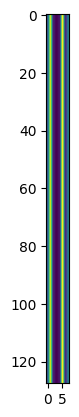

In [144]:
plt.imshow(_a.sequences.detach()[0])

In [136]:
class GRUSeqToSeq(nn.Module):
    def __init__(
            self,
            hidden_size: int, 
            num_layers_gru: int = 1,
            bidirectional: bool = False,
            dropout_gru: float = 0.0
    ) -> None:
        super(GRUSeqToSeq, self).__init__()

        self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers_gru,
            bidirectional=bidirectional,
            dropout=dropout_gru
        )

    def forward(self, x: SingleForwardState) -> SingleForwardState:

        state, _ = self.gru(x.sequences)

        return SingleForwardState(
            sequences=state,
        )

In [138]:
b = GRUSeqToSeq(
    hidden_size=EMB_DIM
)

In [145]:
_b = b(_a)

In [146]:
d(_b.sequences.size())

torch.Size([32, 128, 8])

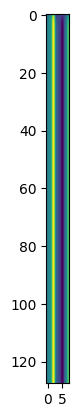

In [147]:
plt.imshow(_b.sequences.detach()[0])

In [149]:
from src.models.components.pooling.agg_pooling import ConvPooling

In [209]:
model = PDESimpleNN(
    layers=[
        ClusteredInputs(),
        MainEncoderLayer(
            embedding_dim=EMB_DIM, 
            dropout_inputs=0.0, 
            num_coords=1
        ),
        GRUSeqToSeq(
            hidden_size=EMB_DIM
        ),
        ConvPooling(
            emb_dim=EMB_DIM
        ),
        LinearDownUpBlock(
            in_features=EMB_DIM,
            out_features=1,
            down=True,
            num_layers=2,
            dropout_rate=0.0,
            activation_type="tanh",
            use_batch_norm=False
        )
    ]
)

In [210]:
model.layers

Sequential(
  (0): ClusteredInputs()
  (1): MainEncoderLayer(
    (dropout): Dropout(p=0.0, inplace=False)
    (branched_linear_block_xyz): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=1, out_features=8, bias=True)
        (1): Tanh()
      )
    )
    (linear_block_t): Sequential(
      (0): Linear(in_features=1, out_features=8, bias=True)
      (1): Tanh()
    )
    (out_linear_block): Linear(in_features=16, out_features=8, bias=True)
  )
  (2): GRUSeqToSeq(
    (gru): GRU(8, 8, batch_first=True)
  )
  (3): ConvPooling(
    (pooling_layer): AllPoolings()
    (agg_layer): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=same, bias=False)
    (batch_norm): Identity()
  )
  (4): LinearDownUpBlock(
    (dropout): Dropout(p=0.0, inplace=False)
    (linear_block): Sequential(
      (0): Sequential(
        (0): Linear(in_features=8, out_features=4, bias=True)
        (1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (2): Tanh()
      )
      (1): Seq

In [211]:
from functools import partial

In [212]:
lit_module = PDELitModule(
    net=model,
    train_batch_size=BATCH_SIZE,
    val_batch_size=BATCH_SIZE,
    conditional_loss="val/loss",
    condition_names=["pdec", "ic"],
    num_coords=1,
    conditions={
        "pdec": PDEBurgerCondition(),
        "ic": [InitialConditions()],
        "other_pdec": [PDEOtherCondition()],
        "bc": []
    },
    bc_limits=[],
    optimizer=partial(torch.optim.Adam, lr=1e-3, weight_decay=1e-4)
)

/home/danil/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [213]:
d(lit_module(sample))

ModelOutput(representations=tensor([[-1.0902e-02,  1.5149e-02, -4.4649e-02, -7.5888e-02,  1.0789e-04,
         -9.2620e-02, -2.6321e-02, -1.9236e-02],
        [ 8.3544e-02,  1.9551e-02, -1.7031e-04, -3.8777e-02,  7.6310e-02,
         -5.6197e-04,  3.3568e-02, -9.2870e-04],
        [-2.2176e-02,  1.9208e-02, -2.2635e-02, -8.6532e-02, -8.6018e-03,
         -9.4315e-02, -2.1711e-02, -1.2019e-02],
        [-5.4100e-04,  1.3391e-02, -6.0256e-02, -6.8892e-02,  7.5314e-03,
         -9.0287e-02, -2.8277e-02, -2.3970e-02],
        [ 1.7203e-02,  1.5327e-02, -7.8187e-02, -6.3863e-02,  2.0509e-02,
         -8.2876e-02, -2.6700e-02, -2.8102e-02],
        [ 2.5995e-02,  3.7155e-02,  9.9613e-02, -3.0234e-03,  4.6394e-02,
         -1.9955e-02,  5.2828e-02,  3.0198e-02],
        [ 7.1114e-02,  1.8756e-02,  1.8328e-02, -2.1276e-02,  6.6160e-02,
          4.7108e-03,  3.6196e-02,  5.2441e-03],
        [ 8.8724e-02,  2.4430e-02, -6.8097e-02, -3.0997e-02,  8.7210e-02,
         -1.8219e-02,  1.6595e-02, -1

In [214]:
from lightning import Trainer

In [215]:
Trainer(max_epochs=3).fit(model=lit_module, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/danil/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Missing logger folder: /home/danil/projects/LHT_PINN/lightning_logs

  | Name                 | Type               | Params | Mode 
--------------------------------------------------------------------
0 | net                  | PDESimpleNN        | 686    | train
1 | pdec                 | PDEBurgerCondition | 0      | train
2 | criterion            | MSELoss            | 0      | train
3 | other_pdec_criterion | ModuleList         | 0      | train
4 | ic_criterion         | ModuleList         | 0      | train
5 | train_loss           | MeanMetric         | 0      | train
6 | train_branched_loss  | ModuleDict         | 0      | train
7 | val_loss             | MeanMetric         | 0      | trai

Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Mismatch in shape: grad_output[0] has a shape of torch.Size([32, 1]) and output[0] has a shape of torch.Size([4096, 1]).

# Pretrained Model

In [30]:
from src.models.pde_lit_model_xt import PDELitModule
from IPython.display import display as d

import torch
from torch import nn

In [31]:
class PretrainedModel(nn.Module):
    def __init__(self, ckpt_path: str):
        super().__init__()
        
        self.net = PDELitModule.load_from_checkpoint(ckpt_path)
        self.net.eval()
        self.net.freeze()

    def forward(self, inputs):
        return self.net(inputs)

In [32]:
train_model = PretrainedModel("logs/train/runs/2024-06-30_22-09-00/checkpoints/epoch_004.ckpt")

/home/danil/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [33]:
d(dict(train_model.net.named_parameters()))

{'net.layers.0.branched_linear_block_xyz.0.0.weight': Parameter containing:
 tensor([[-0.9901],
         [-0.2685],
         [-0.0880],
         [ 0.1273],
         [ 0.8470],
         [-0.2193],
         [ 0.2366],
         [-0.4852]]),
 'net.layers.0.branched_linear_block_xyz.0.0.bias': Parameter containing:
 tensor([-0.3602, -0.9574, -0.2561, -0.8185, -0.1243, -0.0938, -0.8296, -0.5145]),
 'net.layers.0.branched_linear_block_xyz.0.1.weight': Parameter containing:
 tensor([1.2070, 0.9496, 1.6495, 1.1648, 1.2012, 1.1794, 1.2106, 1.5748]),
 'net.layers.0.branched_linear_block_xyz.0.1.bias': Parameter containing:
 tensor([-0.2448,  0.2227,  0.5574, -0.0518, -0.1445, -0.2100,  0.2090,  0.5639]),
 'net.layers.0.branched_linear_block_xyz.1.0.weight': Parameter containing:
 tensor([[-0.7072],
         [ 0.9631],
         [-0.2905],
         [ 0.6155],
         [ 0.2611],
         [-0.9639],
         [ 0.0590],
         [ 0.5350]]),
 'net.layers.0.branched_linear_block_xyz.1.0.bias': Paramet

# Visualize results

In [34]:
from src.data.components.dataset import SpatialTemporalDomain
from src.data.components.collate import ModelInput, Coords

from typing import List

import matplotlib.pyplot as plt

In [51]:
dataset = SpatialTemporalDomain(coords_limits={"x": [-20, 20], "y": [-10, 10]}, time_limits=[0, 10], n_samples=30_000)

x = dataset.coords["x"]
y = dataset.coords["y"]
t = dataset.T

u: List # u = u(x, t)

In [52]:
test_sample = ModelInput(coords=Coords(x=x, y=y, z=None), time=t)

In [53]:
with torch.no_grad():
    u = train_model.net(test_sample).logits

In [54]:
d(u)

tensor([[ 0.0198],
        [-0.0057],
        [-0.0051],
        ...,
        [-0.0291],
        [ 0.0031],
        [-0.0483]])

In [14]:
dt = 1e-1 # Simulation timestep (s)

time = np.arange(0, 10, dt)


for time_coef in time:
    with torch.no_grad():
        u_sample = train_model.net(
            ModelInput(
                coords=Coords(x=x, y=None, z=None), 
                time=torch.ones(size=x.size()) * time_coef
            )
        ).logits

    
    fig = plt.figure(figsize=(8, 8), dpi=300)

    ax = fig.add_subplot() 

    ax.set(xlim=[-2, 2], ylim=[0, 1], xlabel="X", ylabel="u(X, T)")

    ax.scatter(x, u_sample, s=0.1, alpha=0.9, c=u_sample, cmap="plasma")

    plt.savefig(f"pictures/solutions_gif/tmp_jpgs/burger_xt_{round(time_coef, 2)}.jpeg", dpi=300, bbox_inches="tight")

    plt.close()

In [11]:
import glob

from PIL import Image


def make_gif(frame_folder):
    frames = [
        Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*"))
    ][:60]
    frame_one = frames[0]
    frame_one.save(
        "pictures/solutions_gif/my_awesome.gif", format="GIF", append_images=frames, save_all=True, duration=8, loop=0
    )

In [12]:
make_gif("pictures/solutions_gif/tmp_jpgs")

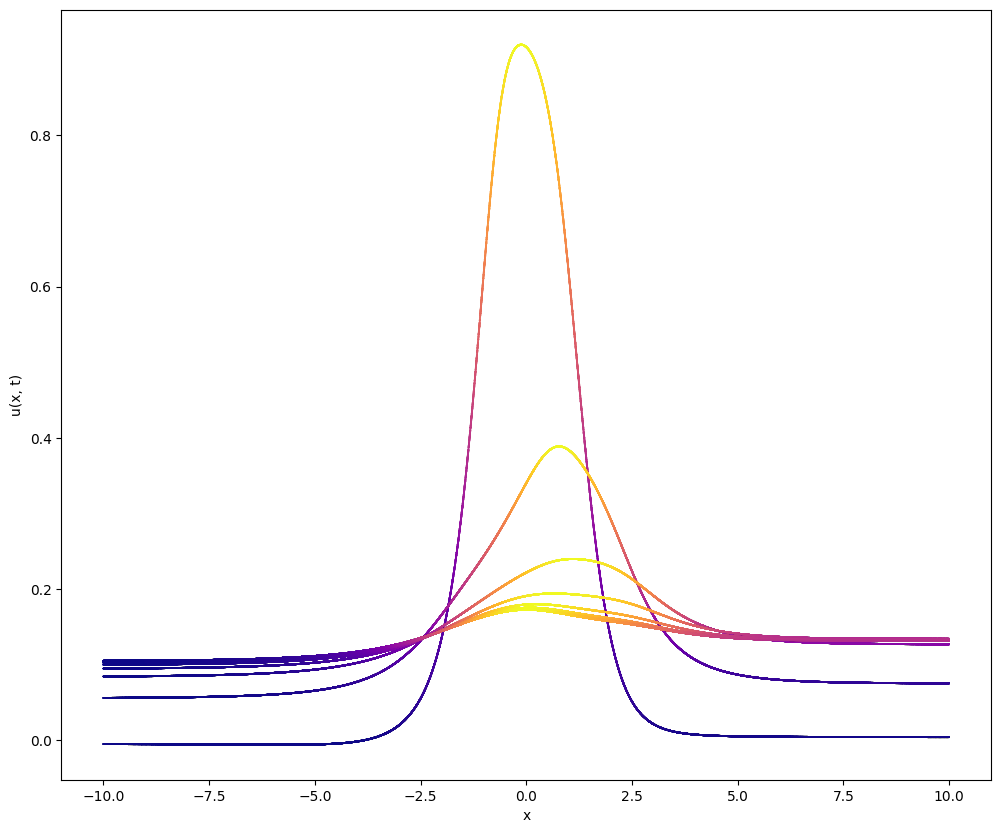

In [63]:
ax = plt.figure(figsize=(12, 10)).add_subplot()


for time_coef in torch.linspace(0, 5, 100):
    with torch.no_grad():
        u_sample = train_model.net(
            ModelInput(
                coords=Coords(x=x, y=None, z=None), 
                time=torch.ones(size=x.size()) * time_coef
            )
        ).logits

    ax.scatter(x, u_sample, s=0.1, alpha=0.9, c=u_sample, cmap="plasma")

ax.set_ylabel("u(x, t)")
ax.set_xlabel("x")

plt.show()

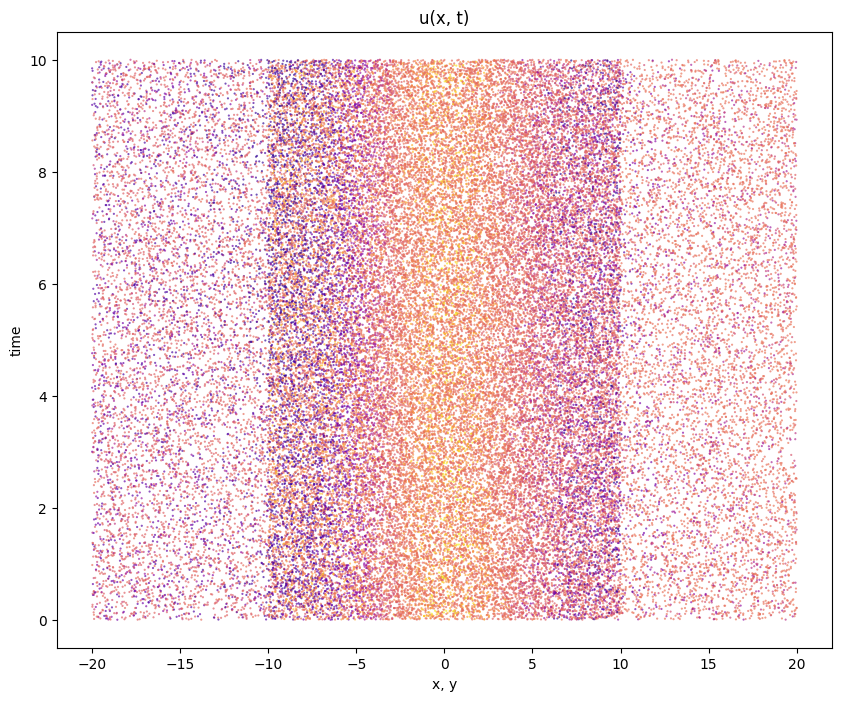

In [55]:
ax = plt.figure(figsize=(10, 8)).add_subplot()

ax.scatter(x, t, s=0.3, c=u, cmap="plasma", alpha=0.7)
ax.scatter(y, t, s=0.3, c=u, cmap="plasma", alpha=0.7)

ax.set_title("u(x, t)")
ax.set_ylabel("time")
ax.set_xlabel("x, y")

plt.show()

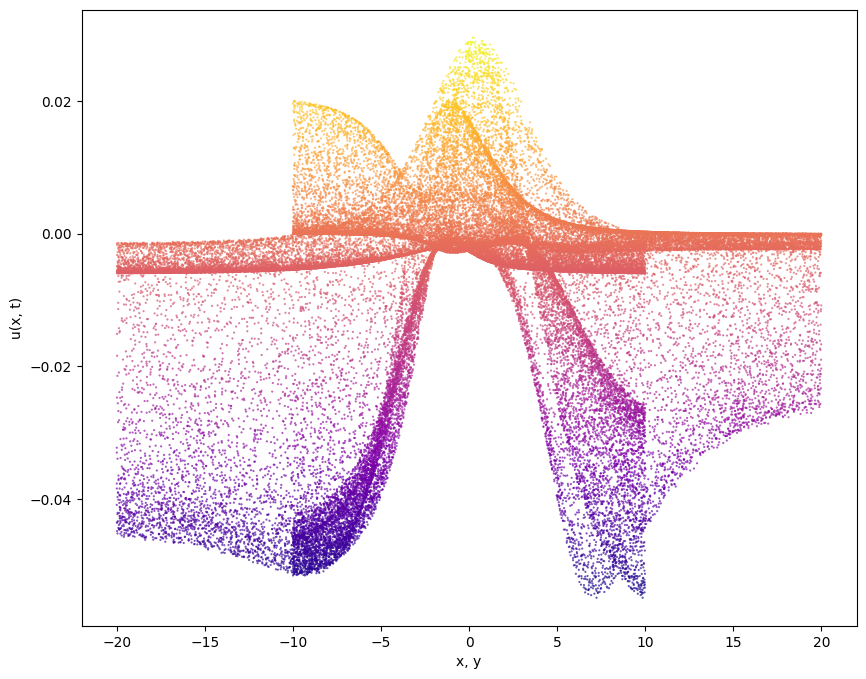

In [56]:
ax = plt.figure(figsize=(10, 8)).add_subplot()

ax.scatter(x, u, s=0.3, c=u, cmap="plasma", alpha=0.7)
ax.scatter(y, u, s=0.3, c=u, cmap="plasma", alpha=0.7)

ax.set_ylabel("u(x, t)")
ax.set_xlabel("x, y")

plt.show()

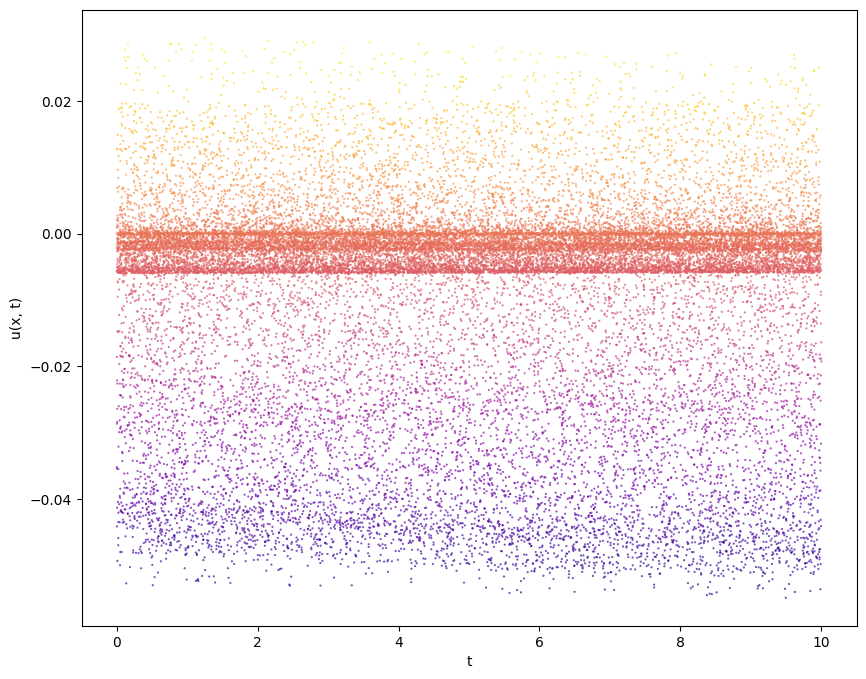

In [57]:
ax = plt.figure(figsize=(10, 8)).add_subplot()

ax.scatter(t, u, s=0.3, c=u, cmap="plasma", alpha=0.7)

ax.set_ylabel("u(x, t)")
ax.set_xlabel("t")

plt.show()

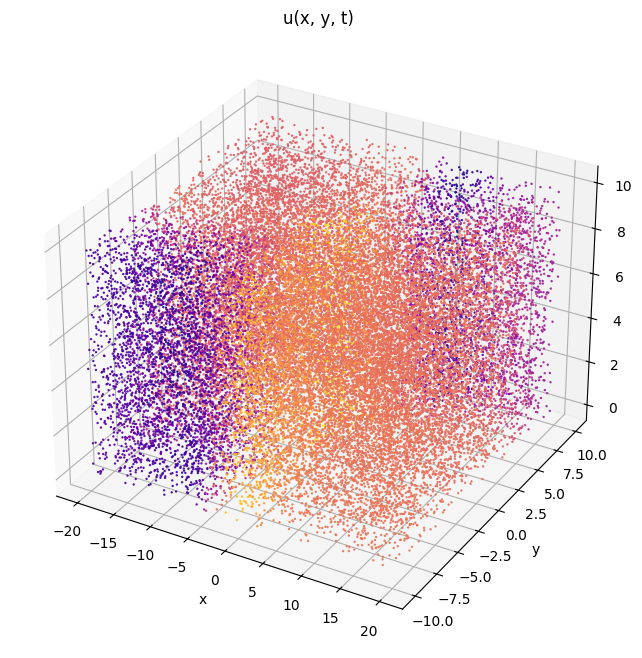

In [58]:
ax = plt.figure(figsize=(10, 8)).add_subplot(projection="3d")

ax.scatter(x, y, t, s=0.5, alpha=0.9, c=u, cmap="plasma")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("u(x, y, t)")

plt.show()

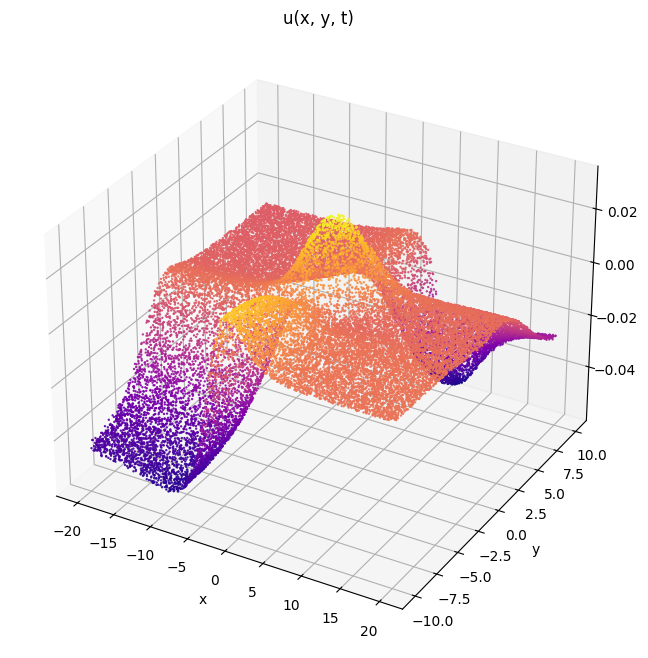

In [59]:
ax = plt.figure(figsize=(10, 8)).add_subplot(projection="3d")

ax.scatter(x, y, u, s=0.5, alpha=0.9, c=u, cmap="plasma")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("u(x, y, t)")

plt.show()

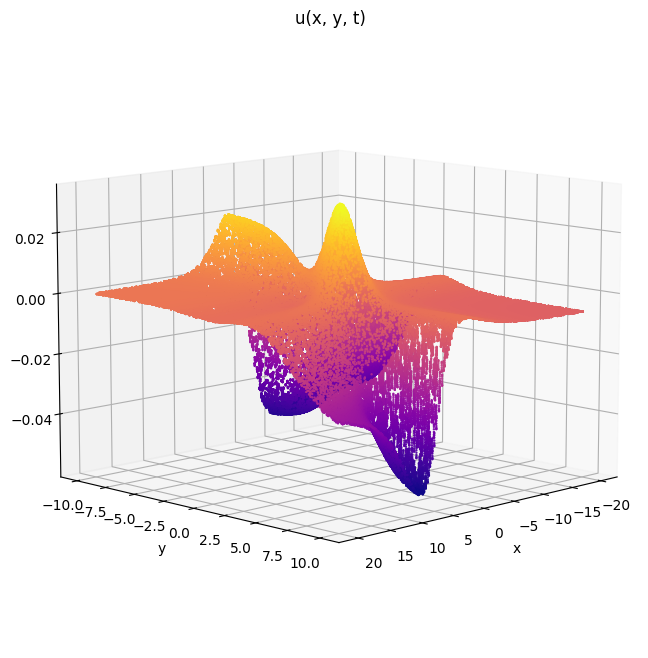

In [60]:
ax = plt.figure(figsize=(10, 8)).add_subplot(projection="3d")


for time_coef in torch.linspace(0, 10, 10):
    with torch.no_grad():
        u_sample = train_model.net(
            ModelInput(
                coords=Coords(x=x, y=y, z=None), 
                time=torch.ones(size=x.size()) * time_coef
            )
        ).logits

    ax.scatter(x, y, u_sample, s=0.5, alpha=0.9, c=u_sample, cmap="plasma")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("u(x, y, t)")

ax.view_init(10, 45)

plt.show()

In [103]:
dt = 1e-1 # Simulation timestep (s)

time = np.arange(0, 3, dt)


for time_coef in time:
    with torch.no_grad():
        u_sample = train_model.net(
            ModelInput(
                coords=Coords(x=x, y=y, z=None), 
                time=torch.ones(size=x.size()) * time_coef
            )
        ).logits

    
    fig = plt.figure(figsize=(8, 8), dpi=300)

    ax = fig.add_subplot(projection="3d")

    ax.set(xlim=[-10, 10], ylim=[-0.1, 0.1], zlim=[-0.1, 0.1], xlabel="X", ylabel="Y", zlabel="u(X, Y, T)")

    ax.scatter(x, y, u_sample, s=0.5, alpha=0.9, c=u_sample, cmap="plasma")

    ax.view_init(10, 45)

    plt.savefig(f"pictures/solutions_gif/tmp_jpgs/burger_xyt_{round(time_coef, 2)}.jpeg", dpi=300, bbox_inches="tight")

    plt.close()

In [104]:
import glob

from PIL import Image


def make_gif(frame_folder):
    frames = [
        Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*"))
    ]
    frame_one = frames[0]
    frame_one.save(
        "pictures/solutions_gif/my_awesome.gif", format="GIF", append_images=frames, save_all=True, duration=15, loop=0
    )

In [105]:
make_gif("pictures/solutions_gif/tmp_jpgs")

In [106]:
!rm -r -f pictures/solutions_gif/tmp_jpgs/*